In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
plt.rcParams.update({'font.size': 18})

In [3]:
# CV prediction for numus
NumuCV = np.array([3.1e3,2.9e3])
# systematic uncertainty, fractional
SYST = 0.2
NBINS = len(NumuCV)
FluxFrac = 1e-1 # nue / numu flux fraction
LEEFrac  = 0.5 # LEE / nue fraction
# degree of correlation between numus and nues and between different energy bins in each channel
CORR = 0.8 

# generate a fluctuation of the numu expectation within stat / syst uncertainties
def RandomNumu(Nbins):
    universeWeight = np.random.normal(1,SYST)
    Nuniverse = NumuCV * universeWeight
    # using sqrt(N) error given high-stats regime
    Nobs = np.random.normal(Nuniverse,np.sqrt(Nuniverse),Nbins)
    return universeWeight,Nobs

# build nue expectation given the numus
def NueExpectation(numus):
    return numus * FluxFrac

# LEE expectation (LEEs only show up in 1st nue bin)
def LEEExpectation(nues,F):
    return np.array([nues[0] * F,0])

In [4]:
# build the H1 expectation under the LEE hypothesis
# universe -> scaling of numus w.r.t. CV prediction
# LEEFrac -> signal strength for LEE / nues
# NBins: number of energy bins of each channel
def H1(universe,LEEFrac,Nbins):
    NnumuUniverse = universe * NumuCV
    numuCV = np.ones(Nbins)
    numuCV *= NnumuUniverse
    nueCV = NueExpectation(numuCV) 
    LEECV = LEEExpectation(nueCV,LEEFrac)
    return (np.array([numuCV, nueCV + LEECV])).flatten()

# build the H0 expectation under the SM hypothesis
# universe -> scaling of numus w.r.t. CV prediction
# LEEFrac -> signal strength for LEE / nues
# NBins: number of energy bins of each channel
def H0(universe,Nbins):
    NnumuUniverse = universe * NumuCV
    numuCV = np.ones(Nbins)
    numuCV *= NnumuUniverse
    nueCV = NueExpectation(numuCV) 
    return (np.array([numuCV, nueCV])).flatten()

In [5]:
# build the covariance matrix given the expected bin-content EXP
# EXP format, in e.g. 2-energy bins: [numu 1st bin, numu 2nd bin, nue 1st bin, nue 2nd bin]
def BuildCovariance(EXP):
    
    V = SYST * EXP
    
    #print (V)
    
    COV_SYST = np.matmul((np.array([V])).T,np.array([V]))
    
    COV_STAT = np.zeros((len(EXP), len(EXP)), float)
    np.fill_diagonal(COV_STAT,EXP) 
    
    for n in range(len(EXP)):
        for m in range(len(EXP)):
            if (n == m): continue
            COV_SYST[n][m] *= CORR

    return COV_SYST + COV_STAT

In [6]:
# calculate the delta-chisq:
# INV -> inverse of covariance matrix
# H0_CV -> H0 "mu" expectation
# H1_CV -> H1 "mu" expectation
# data -> observation
def deltachisq(INV,H0_CV,H1_CV,data):
    diffH0 = (data-H0_CV)
    diffH1 = (data-H1_CV)
    chiH0 = diffH0.dot(INV).dot(diffH0.T)
    chiH1 = diffH1.dot(INV).dot(diffH1.T)
    return (chiH0-chiH1)

In [7]:
# generate a poisson fluctuated dataset
# data -> array of expected bin contents
def StatFluctuation(data):
    ret = np.ones(len(data))
    for i,v in enumerate(data):
        #print ('v : ',v)
        if (v < 0):
            ret[i] = 0
        else:
            ret[i] = np.random.poisson(v)
    return ret

In [8]:
def ToyH0(COV,INV,L,H0_CV,H1_CV,verbose=False):
    NTOT = len(H0_CV)
    # the next two lines generate the toy draw accounting for correlations
    # see slide 11 of 
    # https://microboone-docdb.fnal.gov/cgi-bin/private/RetrieveFile?docid=30100
    v = np.random.normal(0, 1, NTOT) # this replaces "picking a universe"
    xtoy_H0 = H0_CV + v.dot(L)
    # statistically fluctuate this draw
    xtoy_H0 = StatFluctuation(xtoy_H0)
    if (verbose):
        print ('DATA  : ',xtoy_H0)
        print ('MC H0 : ',H0_CV)
        print ('MC H1 : ',H1_CV)
    return deltachisq(INV,H0_CV,H1_CV,xtoy_H0)

def ToyH1(COV,INV,L,H0_CV,H1_CV):
    NTOT = len(H0_CV)
    # the next two lines generate the toy draw accounting for correlations
    # see slide 11 of 
    # https://microboone-docdb.fnal.gov/cgi-bin/private/RetrieveFile?docid=30100
    v = np.random.normal(0, 1, NTOT) # this replaces "picking a universe"
    xtoy_H1 = H1_CV + v.dot(L)
    # statistically fluctuate this draw
    xtoy_H1 = StatFluctuation(xtoy_H1)
    return deltachisq(INV,H0_CV,H1_CV,xtoy_H1)

In [9]:
# chisq_v is the distribution of chisq for H0
# chisq_v_2 "" H1
# return the median chisq (med)
#and the chisq values encompassing 68% of the distribution (Nscan_low, Nscan_hih)
# return also the p-values for the median (f_med) 
# and the +/- 1sigma (f_dn, f_up)
def GetMedian1Sigma(chisq_v,chisq_v_2):
    if (len(chisq_v) != len(chisq_v_2)):
        print ('non-equal lengths! ERROR')
        return -1
    med = np.median(chisq_v)
    Ntot = len(chisq_v)
    lower = -np.inf
    upper = np.inf
    # find lower bound
    Nscan_low = med
    Frac_scanned = 0.
    while (Frac_scanned < 0.34):
        Nscan_low -= med/100.
        Frac_scanned = len(np.where( (chisq_v < med) & (chisq_v  > Nscan_low))[0]) / float(Ntot) 
    # find upper bound
    Nscan_hih = med
    Frac_scanned = 0.
    while (Frac_scanned < 0.34):
        Nscan_hih += med/100.
        Frac_scanned = len(np.where( (chisq_v > med) & (chisq_v  < Nscan_hih))[0]) / float(Ntot)
    
    # what fraction of events in chisq_v_2 are above the calculated values?
    f_med = len(np.where(chisq_v_2 > med)[0]) / float(Ntot)
    f_dn  = len(np.where(chisq_v_2 > Nscan_low)[0]) / float(Ntot)
    f_up  = len(np.where(chisq_v_2 > Nscan_hih)[0]) / float(Ntot)
    
    return med,Nscan_low,Nscan_hih,f_med,f_dn,f_up

In [10]:
# return the constrained COV matrix (see TN)
def ConstrainCOV(COV,OBS):
    # from:
    # https://microboone-docdb.fnal.gov/cgi-bin/private/ShowDocument?docid=7583
    # TN 255
    INV = np.linalg.inv(COV)
    Nbins = int(len(OBS)/2.)
    NUMU_OBS = np.concatenate( (1./np.array(OBS[:Nbins]), np.zeros(Nbins)) )
    BINV = INV + NUMU_OBS
    B = np.linalg.inv(BINV)
    return B,BINV
  
# return the inverse of matrix C (see TN)
def ConstrainCV(COV,CV):
    # from:
    # https://microboone-docdb.fnal.gov/cgi-bin/private/ShowDocument?docid=7583
    # TN 255
    INV = np.linalg.inv(COV)
    Nbins = int(len(CV)/2.)
    NUMU_CV = np.concatenate( (1./np.array(CV[:Nbins]), np.zeros(Nbins)) )
    print ('OBS : ',CV)
    CINV = INV + NUMU_CV
    return CINV

In [11]:
# given a matrix get the nue quadrant only
def GetNueQuadrant(M):
    M1 = np.array(M[NBINS:])
    Nrow = len(M1)
    C = np.array([M1[n][NBINS:] for n in range(Nrow)])
    return C

In [12]:
# Run the simulation
# S -> signal scaling for the LEE w.r.t. nues
# W_CV -> how much to scale the numus by for the CV expectation. e.g. 1 -> no additional scaling.
# W_OBS -> how much to scale the numus for the observation. e.g. 0.8 -> observe 20% less numus then predicted

In [13]:
S = 0.5 # injected LEE signal strength
W_CV = 1.0 # CV weight
W_OBS = 0.8 # observed weight

# Asimov dataset
H1_CV = H1(W_CV,S,NBINS)
H0_CV = H0(W_CV,NBINS)

print ('Asimov H0 bin contents : ',H0_CV)

# build the covariance matrix
COV = BuildCovariance(H0_CV)
INV = np.linalg.inv(COV)

# get the nue only portion of the covariance matrix
COV_nue = GetNueQuadrant(COV)
INV_nue = GetNueQuadrant(INV)

# measure numus
H1_uni = H1(W_OBS,S,NBINS)
H0_uni = H0(W_OBS,NBINS)
H1_obs = StatFluctuation(H1_uni)
print ('Observed bin contents (w/ LEE model) : ',H1_obs)

# from:
# https://microboone-docdb.fnal.gov/cgi-bin/private/ShowDocument?docid=7583
# TN 255
B,BINV = ConstrainCOV(COV,H1_obs)
CINV = ConstrainCV(COV,H1_CV)

# updated nue prediction based on constraint
NfitH0 = (H0_CV.dot(CINV).dot(B))


# grab only the nue portion of the fit and constrained COV matrix
NfitH0_nue = np.array(NfitH0[NBINS:])
B_nue = GetNueQuadrant(B)
BINV_nue = GetNueQuadrant(BINV)
print ('nue prediction after constraint (SM model) : ',NfitH0_nue)

COVH1 = BuildCovariance(H1_CV)

BH1,BINVH1 = ConstrainCOV(COVH1,H1_obs)
CINVH1 = ConstrainCV(COVH1,H1_CV)

NfitH1 = (H1_CV.dot(CINVH1).dot(BH1))

NfitH0_nue = np.array(NfitH0[NBINS:])
NfitH1_nue = np.array(NfitH1[NBINS:])

# constrained diagonal errors on nues
nue_err = np.sqrt(np.diag(B))[NBINS:]

L = np.linalg.cholesky(COV)
L2 = np.linalg.cholesky(B)

L_nue = np.linalg.cholesky(COV_nue)
L2_nue = np.linalg.cholesky(B_nue)

Asimov H0 bin contents :  [3100. 2900.  310.  290.]
Observed bin contents (w/ LEE model) :  [2410. 2304.  376.  225.]
OBS :  [3100. 2900.  465.  290.]
nue prediction after constraint (SM model) :  [255.54926712 239.06221763]
OBS :  [3100. 2900.  465.  290.]


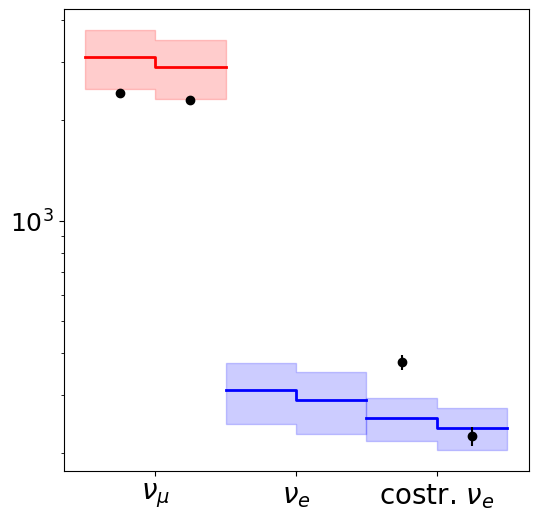

In [14]:
xvals_numu = []
H0_CV_plot_numu = []

xvals_nue = []
xvals_nue_constr = []
H0_CV_plot_nue = []
H0_CV_plot_nue_constr = []

H0_CV_plot_nue_constr_high = []
H0_CV_plot_nue_constr_low = []


for n in range(NBINS):
    
    xvals_numu.append(n-0.5)
    xvals_numu.append(n+0.5)
    H0_CV_plot_numu.append(H0_CV[n])
    H0_CV_plot_numu.append(H0_CV[n])

    xvals_nue.append(NBINS+n-0.5)
    xvals_nue.append(NBINS+n+0.5)
    H0_CV_plot_nue.append(H0_CV[NBINS+n])
    H0_CV_plot_nue.append(H0_CV[NBINS+n])
    
    xvals_nue_constr.append(NBINS*2+n-0.5)
    xvals_nue_constr.append(NBINS*2+n+0.5)
    
    H0_CV_plot_nue_constr.append(NfitH0[NBINS+n])
    H0_CV_plot_nue_constr.append(NfitH0[NBINS+n])
    
    H0_CV_plot_nue_constr_high.append(NfitH0[NBINS+n]+nue_err[n])
    H0_CV_plot_nue_constr_high.append(NfitH0[NBINS+n]+nue_err[n])    
    H0_CV_plot_nue_constr_low.append(NfitH0[NBINS+n]-nue_err[n])
    H0_CV_plot_nue_constr_low.append(NfitH0[NBINS+n]-nue_err[n])
    
    
xvals_numu = np.array(xvals_numu) 
xvals_nue  = np.array(xvals_nue) 
H0_CV_plot_numu = np.array(H0_CV_plot_numu)
H0_CV_plot_nue  = np.array(H0_CV_plot_nue)
    
fig = plt.figure(figsize=(6,6))

plt.plot(xvals_numu,H0_CV_plot_numu,'r-',lw=2)
plt.plot(xvals_nue,H0_CV_plot_nue,'b-',lw=2)
plt.plot(xvals_nue_constr,H0_CV_plot_nue_constr,'b-',lw=2)

plt.fill_between(xvals_numu,\
                 H0_CV_plot_numu*(1-SYST),\
                 H0_CV_plot_numu*(1+SYST),\
                 color='r',alpha=0.2)

Err_nue_unconstr = np.sqrt( (H0_CV_plot_nue * SYST)**2 + H0_CV_plot_nue )

plt.fill_between(xvals_nue,\
                 H0_CV_plot_nue - Err_nue_unconstr,\
                 H0_CV_plot_nue + Err_nue_unconstr,\
                 color='b',alpha=0.2)

plt.fill_between(xvals_nue_constr,\
                 H0_CV_plot_nue_constr_low,\
                 H0_CV_plot_nue_constr_high,\
                 color='b',alpha=0.2)

plt.errorbar([0,1],H1_obs[:NBINS],yerr=np.sqrt(H1_obs[:NBINS]),fmt='o',color='k')
plt.errorbar([4,5],H1_obs[NBINS:],yerr=np.sqrt(H1_obs[NBINS:]),fmt='o',color='k')

plt.yscale('log')

plt.xticks([0.5,2.5,4.5],labels=[r'$\nu_{\mu}$',r'$\nu_e$',r'costr. $\nu_e$'],\
           fontsize=20)

plt.show()

In [15]:
# draw toys to calculate delta-chisq distributions

chisq_H0_Asimov_v = []
chisq_H1_Asimov_v = []

chisq_H0_Constr_v = []
chisq_H1_Constr_v = []

chisq_H0_Constr_full_v = []
chisq_H1_Constr_full_v = []

for n in range(30000):
    
    chisq_H0_Asimov_v.append(ToyH0(COV,INV,L,H0_CV,H1_CV))
    chisq_H1_Asimov_v.append(ToyH1(COV,INV,L,H0_CV,H1_CV))
    
    # full cov
    chisq_H1_Constr_full_v.append(ToyH1(B,BINV,L2,NfitH0,NfitH1))
    chisq_H0_Constr_full_v.append(ToyH0(B,BINV,L2,NfitH0,NfitH1))
    
    # nue cov only
    chisq_H1_Constr_v.append(ToyH1(B_nue,BINV_nue,L2_nue,NfitH0_nue,NfitH1_nue))
    chisq_H0_Constr_v.append(ToyH0(B_nue,BINV_nue,L2_nue,NfitH0_nue,NfitH1_nue))

In [16]:
import scipy.stats as st

p-value : 0.0018 in range [0.0313, 0.0000]
p-value : 0.0010 in range [0.0184, 0.0000]


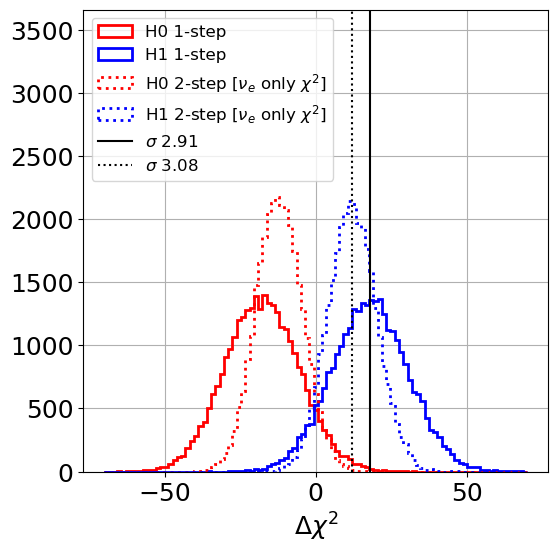

In [17]:
BINS = np.linspace(-70,70,100)

fig = plt.figure(figsize=(6,6))

plt.hist(chisq_H0_Asimov_v,bins=BINS,histtype='step',lw=2,color='r',linestyle='-',label='H0 1-step')
plt.hist(chisq_H1_Asimov_v,bins=BINS,histtype='step',lw=2,color='b',linestyle='-',label='H1 1-step')

plt.hist(chisq_H0_Constr_v,bins=BINS,histtype='step',lw=2,color='r',\
         linestyle='dotted',label=r'H0 2-step [$\nu_e$ only $\chi^2$]')
plt.hist(chisq_H1_Constr_v,bins=BINS,histtype='step',lw=2,color='b',\
         linestyle='dotted',label=r'H1 2-step [$\nu_e$ only $\chi^2$]')

med,m1sig,p1sig,pval,p1dn,p1up = GetMedian1Sigma(chisq_H1_Asimov_v,chisq_H0_Asimov_v)
print ('p-value : %.04f in range [%.04f, %.04f]'%(pval,p1dn,p1up))
plt.axvline(med,color='k',linestyle='-',label=r'$\sigma$ %.2f'%(st.norm.ppf(1-pval)))

med,m1sig,p1sig,pval,p1dn,p1up = GetMedian1Sigma(chisq_H1_Constr_v,chisq_H0_Constr_v)
print ('p-value : %.04f in range [%.04f, %.04f]'%(pval,p1dn,p1up))
plt.axvline(med,color='k',linestyle='dotted',label=r'$\sigma$ %.2f'%(st.norm.ppf(1-pval)))

plt.ylim(0., plt.ylim()[1]*1.6)
plt.xlabel(r'$\Delta\chi^2$')
plt.legend(fontsize=12)
plt.grid()
plt.show()